In [2]:
import pandas as pd
import numpy as np
import torch
import time
from datetime import datetime
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from scipy.stats import norm

# CIFAR-10 constituent samples' extraction
This notebook shows how to construct a dataset that has only CIFAR samples. This can be used for other tasks or for assessment of models trained on the imagenet constituents, to understand how well these models deal with distribution shift. 

#### ENSURE THAT CINIC-10 IS DOWNLOADED AND STORED IN ../data/cinic-10

In [13]:
percy_cifar_file = '../selection_model/backup/cifar10.csv'
percy_unlab_file = '../selection_model/backup/unlabeled_percy_500k.csv'
det1_cifar_file = '../selection_model/tail_only_cifar_random/cifar10.csv'
det1_unlab_file = '../selection_model/tail_only_cifar_random/unlabeled_percy_500k.csv'
det2_cifar_file = '../selection_model/head_only_cifar_random/cifar10.csv'
det2_unlab_file = '../selection_model/head_only_cifar_random/unlabeled_percy_500k.csv'



percy_cifar_df = pd.read_csv(percy_cifar_file)
det1_cifar_df = pd.read_csv(det1_cifar_file)
det2_cifar_df = pd.read_csv(det2_cifar_file)

percy_unlab_df = pd.read_csv(percy_unlab_file)
det1_unlab_df = pd.read_csv(det1_unlab_file)
det2_unlab_df = pd.read_csv(det2_unlab_file)

# det1_unlab_df.set_index(['0']).sort_index()

percy_cifar_df = percy_cifar_df.set_index(['0']).sort_index()
det1_cifar_df = det1_cifar_df.set_index(['0']).sort_index()
det2_cifar_df = det2_cifar_df.set_index(['0']).sort_index()
percy_unlab_df = percy_unlab_df.set_index(['0']).sort_index()
det1_unlab_df = det1_unlab_df.set_index(['0']).sort_index()
det2_unlab_df = det2_unlab_df.set_index(['0']).sort_index()


In [14]:
det1_unlab_df[:10]

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,26
0,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,0.908350,5.684841e-03,6.064987e-06,5.076902e-05,7.205032e-07,7.168614e-08,2.545724e-08,2.648339e-04,4.533418e-03,...,4.338251e-05,1.589561e-03,9.975646e-04,0.002026,0.009164,0.0,0.0,1.0,1.0,0.0
1.0,0.0,0.606798,2.673980e-05,3.452880e-02,2.528734e-03,5.606723e-05,6.282763e-06,2.621203e-04,2.106583e-03,1.151577e-03,...,1.557609e-03,1.090735e-03,2.557549e-04,0.001451,0.000336,0.0,0.0,1.0,1.0,0.0
2.0,0.0,0.996666,1.851517e-06,5.751728e-05,3.037299e-03,9.929483e-05,1.864851e-05,6.536143e-05,3.546547e-06,1.483765e-05,...,1.608416e-05,1.176875e-04,2.217763e-05,0.000170,0.000540,0.0,0.0,1.0,1.0,0.0
3.0,0.0,0.996742,7.147156e-08,3.243061e-03,2.282391e-06,1.317744e-07,1.230870e-08,1.229862e-07,2.301007e-08,1.189674e-05,...,1.989589e-07,3.756565e-06,5.139817e-07,0.000051,0.000001,0.0,0.0,1.0,1.0,0.0
4.0,0.0,0.983741,2.151168e-04,3.190377e-05,1.101671e-05,3.549780e-07,3.037118e-08,6.271934e-08,2.919392e-08,1.597780e-02,...,8.013999e-09,7.589141e-08,1.155872e-07,0.000002,0.000002,0.0,0.0,1.0,1.0,0.0
5.0,0.0,0.938204,5.722750e-03,1.776674e-02,4.011860e-05,7.281783e-05,4.590566e-05,9.685355e-05,3.578826e-02,7.547791e-05,...,6.087443e-07,5.626130e-06,1.159703e-06,0.000014,0.000071,0.0,0.0,1.0,1.0,0.0
6.0,0.0,0.216978,6.149280e-06,1.431456e-05,7.812307e-01,4.565482e-04,2.277367e-05,2.424725e-05,2.067573e-05,2.977478e-05,...,2.348131e-03,2.256427e-04,1.312538e-04,0.000247,0.000083,3.0,0.0,1.0,1.0,0.0
7.0,0.0,0.025807,5.338416e-03,5.051573e-03,2.358190e-01,2.603254e-03,1.038156e-02,6.740900e-01,5.279568e-03,2.926148e-02,...,1.363495e-05,1.954912e-06,6.193921e-06,0.000002,0.000008,6.0,0.0,1.0,1.0,0.0
8.0,0.0,0.999004,1.558730e-06,3.375734e-07,1.045710e-07,2.133294e-06,1.848210e-09,2.564684e-09,1.195600e-06,8.018329e-04,...,1.462338e-08,8.850925e-08,6.919020e-07,0.000006,0.000116,0.0,0.0,1.0,1.0,0.0


In [54]:
det1_unlab_df.set_index(['0']).sort_index().iloc[:,0:13]

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,,,,,,,,,,,,,
0.0,1.0,2.347424e-04,4.225856e-04,8.960764e-07,1.417466e-04,5.004354e-07,1.015913e-06,6.063815e-07,5.018709e-04,2.135953e-03,9.548924e-02,0.901071,9.506175e-01
1.0,0.0,1.340621e-02,1.224775e-06,1.533049e-03,3.165862e-02,2.720618e-05,3.121074e-04,2.735275e-05,9.313998e-02,5.486802e-04,1.157098e-04,0.859230,9.923643e-01
2.0,0.0,1.337249e-02,1.009790e-06,6.721138e-06,1.389310e-06,7.884748e-04,1.341716e-08,8.976202e-07,2.031705e-05,2.551098e-04,2.349913e-05,0.985530,9.936804e-01
3.0,0.0,9.999945e-01,1.931881e-10,1.516543e-07,6.053197e-12,1.657435e-09,2.627541e-13,1.041761e-12,9.455037e-12,2.293339e-09,2.805319e-11,0.000005,9.946308e-01
4.0,0.0,9.999446e-01,2.736295e-08,6.779736e-08,5.632967e-10,1.421216e-11,1.420289e-11,5.312928e-11,1.099596e-09,3.835051e-06,5.491066e-07,0.000051,9.999930e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995.0,9.0,9.008208e-09,1.177607e-05,1.804515e-07,3.466860e-05,1.043286e-07,1.399483e-06,6.709046e-07,1.033276e-07,1.468464e-09,2.056778e-02,0.979383,1.034075e-04
499996.0,9.0,9.008208e-09,1.177607e-05,1.804515e-07,3.466860e-05,1.043286e-07,1.399483e-06,6.709046e-07,1.033276e-07,1.468464e-09,2.056778e-02,0.979383,1.034075e-04
499997.0,9.0,2.986796e-04,2.090707e-05,4.879881e-08,2.076729e-07,7.924388e-08,2.287186e-07,5.218118e-09,5.162094e-05,5.393905e-05,6.765577e-01,0.323017,1.284103e-02


In [50]:
percy_unlab_df.set_index(['0']).sort_index()

,1,2,3,4,5,6,7,8,9,10,...,18,19,20,21,22,23,24,25,26,27
0,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,9.983304e-01,1.206303e-04,4.842660e-05,3.365423e-05,2.902081e-05,1.651228e-05,2.088058e-05,2.409034e-05,8.181608e-05,...,4.338216e-05,1.589537e-03,9.975549e-04,0.002026,0.009164,0.0,0.0,1.0,1.0,0.0
1.0,0.0,9.983302e-01,6.870825e-05,3.817831e-05,4.008432e-05,3.545622e-05,2.532840e-05,2.133699e-05,1.741033e-05,6.229548e-05,...,1.557611e-03,1.090740e-03,2.557546e-04,0.001451,0.000336,0.0,0.0,1.0,1.0,0.0
2.0,0.0,9.983302e-01,2.924052e-05,3.431638e-05,2.538290e-05,2.143321e-05,7.566500e-06,1.748596e-05,1.224295e-05,3.669542e-05,...,1.608410e-05,1.176874e-04,2.217756e-05,0.000170,0.000540,0.0,0.0,1.0,1.0,0.0
3.0,0.0,9.983304e-01,5.588313e-05,1.130922e-04,4.718927e-05,4.757962e-05,2.135059e-05,4.070434e-05,2.978640e-05,6.301712e-05,...,1.989582e-07,3.756561e-06,5.139806e-07,0.000051,0.000001,0.0,0.0,1.0,1.0,0.0
4.0,0.0,9.983304e-01,9.569275e-05,1.309228e-04,6.643942e-05,6.022766e-05,3.555937e-05,5.837404e-05,4.661718e-05,1.060857e-04,...,8.014045e-09,7.589171e-08,1.155882e-07,0.000002,0.000002,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995.0,9.0,1.962221e-06,6.637567e-07,7.873125e-07,9.149505e-07,8.260097e-07,7.896587e-07,2.206883e-06,1.384957e-06,2.043160e-06,...,1.012683e-04,1.211352e-04,1.733482e-05,0.000018,0.994449,9.0,9.0,1.0,1.0,0.0
499996.0,9.0,1.962221e-06,6.637567e-07,7.873125e-07,9.149505e-07,8.260097e-07,7.896587e-07,2.206883e-06,1.384957e-06,2.043160e-06,...,1.012683e-04,1.211352e-04,1.733482e-05,0.000018,0.994449,9.0,9.0,1.0,1.0,0.0
499997.0,9.0,1.319113e-06,1.018375e-06,7.024490e-07,6.437642e-07,9.699455e-07,5.540060e-07,9.103283e-07,1.320638e-06,1.885545e-06,...,3.207422e-07,2.818269e-06,7.865666e-06,0.000360,0.986751,9.0,9.0,1.0,1.0,0.0


In [15]:
print(percy_cifar_df.shape)
print(det1_cifar_df.shape)
print(det2_cifar_df.shape)
print(percy_unlab_df.shape)
print(det1_unlab_df.shape)
print(det2_unlab_df.shape)

(10000, 27)
(10000, 26)
(10000, 26)
(500000, 27)
(500000, 26)
(500000, 26)


In [6]:
ti_df[0:5].iloc[:,0:15]

NameError: name 'ti_df' is not defined

In [16]:
percy_cifar_scores = percy_cifar_df.iloc[:,1:12]
det1_cifar_scores = det1_cifar_df.iloc[:,1:11]
det2_cifar_scores = det2_cifar_df.iloc[:,1:11]
percy_unlab_scores = percy_unlab_df.iloc[:,1:12]
det1_unlab_scores = det1_unlab_df.iloc[:,1:11]
det2_unlab_scores = det2_unlab_df.iloc[:,1:11]


# br_base_scores = br_df.iloc[:,13:23]
base_cifar_scores = det1_cifar_df.iloc[:,11:21]
# cinic_base_scores = cinic_df.iloc[:,13:23]
# ti_base_scores = ti_df.iloc[:,13:23]
base_unlab_scores = det1_cifar_df.iloc[:,11:21]
# cinic_train_base_scores = cinic_train_df.iloc[:,13:23]

percy_cifar_targets = percy_cifar_df.iloc[:,0]
det1_cifar_targets = det1_cifar_df.iloc[:,0]
det2_cifar_targets = det2_cifar_df.iloc[:,0]
percy_unlab_targets = percy_unlab_df.iloc[:,0]
det1_unlab_targets = det1_unlab_df.iloc[:,0]
det2_unlab_targets = det2_unlab_df.iloc[:,0]

percy_cifar_preds = percy_cifar_df.iloc[:,22]
det1_cifar_preds = det1_cifar_df.iloc[:,21]
det2_cifar_preds = det2_cifar_df.iloc[:,21]
percy_unlab_preds = percy_unlab_df.iloc[:,22]
det1_unlab_preds = det1_unlab_df.iloc[:,21]
det2_unlab_preds = det2_unlab_df.iloc[:,21]

# br_base_preds = br_df.iloc[:,23]
base_cifar_preds = det1_cifar_df.iloc[:,22]
# cinic_base_preds = cinic_df.iloc[:,23]
# ti_base_preds = ti_df.iloc[:,23]
base_unlab_preds = det1_cifar_df.iloc[:,22]
# cinic_train_base_preds = cinic_train_df.iloc[:,23]


In [17]:
percy_cifar_targets

0
0.0       3.0
1.0       8.0
2.0       8.0
3.0       0.0
4.0       6.0
         ... 
9995.0    8.0
9996.0    3.0
9997.0    5.0
9998.0    1.0
9999.0    7.0
Name: 1, Length: 10000, dtype: float64

In [18]:
(percy_cifar_targets == det1_cifar_targets).sum()

10000

In [152]:
# br_det_scores[0:5]
print(ti_det_scores[0:5])
print(ti_base_scores[0:5])
print(ti_targets[0:5])
print(ti_preds[0:5])
print(ti_base_preds[0:5])

          2         3         4         5         6         7         8  \
0  0.000220  0.000211  0.000197  0.000225  0.000130  0.000250  0.000172   
1  0.000155  0.000345  0.000100  0.000227  0.000155  0.000198  0.000107   
2  0.000088  0.000160  0.000043  0.000101  0.000028  0.000040  0.000047   
3  0.000144  0.000244  0.000186  0.000104  0.001363  0.000279  0.000143   
4  0.000099  0.000153  0.000089  0.000074  0.000080  0.000097  0.000085   

          9        10        11        12  
0  0.000123  0.000252  0.000345  0.997875  
1  0.000221  0.000191  0.000351  0.997950  
2  0.000017  0.000022  0.000042  0.999411  
3  0.000348  0.000160  0.000183  0.996845  
4  0.000123  0.000167  0.000169  0.998864  
         13        14        15        16        17        18        19  \
0  0.004904  0.000222  0.050344  0.117854  0.043294  0.763045  0.001195   
1  0.782901  0.001761  0.029430  0.021935  0.001235  0.000380  0.012634   
2  0.762853  0.046946  0.000054  0.007641  0.022469  0.00724

In [135]:
# (pd.to_numeric(cifar_det_scores.iloc[:,0:10].idxmax(axis=1)) - 2 == cifar_targets).sum()
# (cifar_preds == cifar_targets).sum()
((pd.to_numeric(cifar_det_scores.iloc[:,0:10].idxmax(axis=1)) - 2) == cifar_targets).sum()
# pd.to_numeric(cifar_det_scores[cifar_preds == 10].iloc[:,0:10].idxmax(axis=1)) -  2
# ((pd.to_numeric(cifar_det_scores[cifar_preds == 10].iloc[:,0:10].idxmax(axis=1)) - 2) == cifar_targets[cifar_preds == 10]).sum()

# ((pd.to_numeric(cifar_det_scores[cifar_preds != 10].iloc[:,0:10].idxmax(axis=1)) - 2) == cifar_targets[cifar_preds != 10]).sum()

# (cifar_preds == 10).sum()

# (cifar_base_preds[cifar_preds != 10] == cifar_targets[cifar_preds != 10]).sum()
# len(cifar_targets)

9613

In [153]:
def verify(df, df_det_scores, df_base_scores, df_targets, df_preds, df_base_preds):
    cifar10_correct = ((pd.to_numeric(df_det_scores.iloc[:,0:10].idxmax(axis=1)) - 2) == df_targets).sum()
    total = len(df_targets)
    
    predti_pseudo_corr = ((pd.to_numeric(df_det_scores[df_preds == 10].iloc[:,0:10].idxmax(axis=1)) - 2) == df_targets[df_preds == 10]).sum()
    predcifar_corr = ((pd.to_numeric(df_det_scores[df_preds != 10].iloc[:,0:10].idxmax(axis=1)) - 2) == df_targets[df_preds != 10]).sum()
    
    predti_count = (df_preds == 10).sum()
    predcifar_count = (df_preds != 10).sum()
    
    base_cifar_correct = (df_base_preds == df_targets).sum()
    base_predcifar_correct = (df_base_preds[df_preds != 10] == df_targets[df_preds != 10]).sum()
    base_predti_correct = (df_base_preds[df_preds == 10] == df_targets[df_preds == 10]).sum()
    
    print("Total %d cifar10 correct %d" %(total, cifar10_correct))
    print("Predicted c10 count %d predicted c10 correct %d, predicted ti count %d pred ti pseudo correct %d" \
              %(predcifar_count, predcifar_corr, predti_count, predti_pseudo_corr))
    print("base cifar10 correct %d, base pred c10 corect  %d, base predicted ti correct %d" \
                  %(base_cifar_correct, base_predcifar_correct, base_predti_correct))
    
    print('------------------------------------------------------------------------')
    

In [154]:
verify(cifar_df, cifar_det_scores, cifar_base_scores, cifar_targets, cifar_preds, cifar_base_preds)
verify(br_df, br_det_scores, br_base_scores, br_targets, br_preds, br_base_preds)
verify(cinic_df, cinic_det_scores, cinic_base_scores, cinic_targets, cinic_preds, cinic_base_preds)
verify(ti_df, ti_det_scores, ti_base_scores, ti_targets, ti_preds, ti_base_preds)

verify(cifar_train_df, cifar_train_det_scores, cifar_train_base_scores, cifar_train_targets, cifar_train_preds, cifar_train_base_preds)
verify(cinic_train_df, cinic_train_det_scores, cinic_train_base_scores, cinic_train_targets, cinic_train_preds, cinic_train_base_preds)

Total 10000 cifar10 correct 9613
Predicted c10 count 9154 predicted c10 correct 8998, predicted ti count 846 pred ti pseudo correct 615
base cifar10 correct 9208, base pred c10 corect  8684, base predicted ti correct 524
------------------------------------------------------------------------
Total 2021 cifar10 correct 1828
Predicted c10 count 1583 predicted c10 correct 1527, predicted ti count 438 pred ti pseudo correct 301
base cifar10 correct 1682, base pred c10 corect  1429, base predicted ti correct 253
------------------------------------------------------------------------
Total 70000 cifar10 correct 49719
Predicted c10 count 42331 predicted c10 correct 37084, predicted ti count 27669 pred ti pseudo correct 12635
base cifar10 correct 45902, base pred c10 corect  34699, base predicted ti correct 11203
------------------------------------------------------------------------
Total 50000 cifar10 correct 3472
Predicted c10 count 1644 predicted c10 correct 368, predicted ti count 4835

In [126]:
df, df_det_scores, df_base_scores, df_targets, df_preds, df_base_preds = (cifar_df, cifar_det_scores, cifar_base_scores, cifar_targets, cifar_preds, cifar_base_preds)

In [140]:
br_det_scores[br_preds==10].iloc[:,-1]

10      0.998449
12      0.999129
15      0.632341
23      0.999399
25      0.790526
          ...   
2005    0.999652
2008    0.998796
2011    0.985885
2016    0.615684
2017    0.999631
Name: 12, Length: 438, dtype: float64

In [19]:
def plot_df_simple_hist(df):
    plt.figure()
    plt.hist(df, bins = 100, histtype = 'bar')
    title = "Softmax confidence Fit results: count = %d" % (len(df))
    plt.title(title)
    plt.xlabel("Max confidence of softmax outputs")
    plt.ylabel('Count')
    # plt.title('Histogram of cross entropy loss for unlabeled data')
    plt.show()

In [20]:
def plot_df_hist(df):
    mu, std = norm.fit(df)
    plt.figure()
    plt.hist(df, bins = 100, histtype = 'bar')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Softmax confidence Fit results: mu = %.2f,  std = %.2f, count = %d" % (mu, std, len(df))
    plt.title(title)
    plt.xlabel("Max confidence of softmax outputs")
    plt.ylabel('Count')
    # plt.title('Histogram of cross entropy loss for unlabeled data')
    plt.show()

In [21]:
def plot_det_11thclass_conf_on_hard_part_hist(df_det_scores, df_preds):
    assert len(df_det_scores) == len(df_preds), 'length of dfs unequal'
    plot_df_hist(df_det_scores[df_preds==10].iloc[:,-1])

def plot_det_top_conf_on_hard_part_hist(df_det_scores, df_preds):
    assert len(df_det_scores) == len(df_preds), 'length of dfs unequal'
    df_hard_part_scores = df_det_scores[df_preds==10].iloc[:,0:10]
    plot_df_hist(df_hard_part_scores.max(axis=1))

def plot_base_top_conf_on_hard_part_hist(df_base_scores, df_preds):
    assert len(df_base_scores) == len(df_preds), 'length of dfs unequal'
    df_hard_part_scores = df_base_scores[df_preds==10]
    plot_df_hist(df_hard_part_scores.max(axis=1))
    
def plot_det_top_conf_hist(df_det_scores):
    plot_df_hist(df_det_scores.max(axis=1))

In [12]:
df_det_scores[df_preds==10][0:10]

NameError: name 'df_det_scores' is not defined

In [182]:
df_det_scores[df_preds==10][0:10].iloc[:,0:10].max(axis=1)

2      0.434786
6      0.338432
22     0.272263
26     0.273538
37     0.114180
47     0.000310
59     0.131193
81     0.014478
85     0.198837
117    0.289972
dtype: float64

Ben recht plot


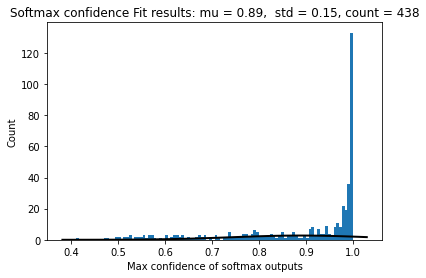

Tiny images plot


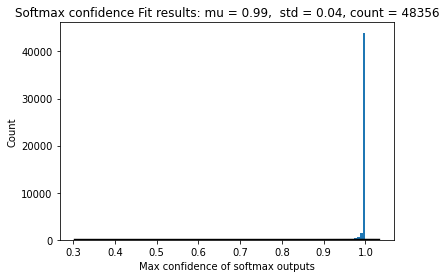

Cifat test plot


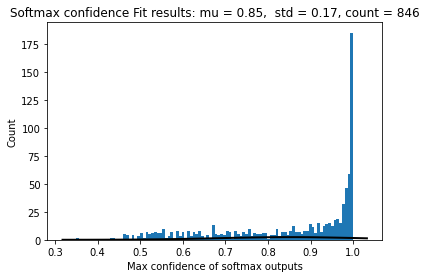

Cifar train plot


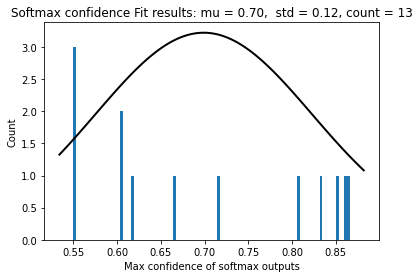

In [184]:
print("Ben recht plot")
plot_det_11thclass_conf_on_hard_part_hist(br_det_scores, br_preds)
print("Tiny images plot")
plot_det_11thclass_conf_on_hard_part_hist(ti_det_scores, ti_preds)
print("Cifat test plot")
plot_det_11thclass_conf_on_hard_part_hist(cifar_det_scores, cifar_preds)
print("Cifar train plot")
plot_det_11thclass_conf_on_hard_part_hist(cifar_train_det_scores, cifar_train_preds)

Ben recht plot


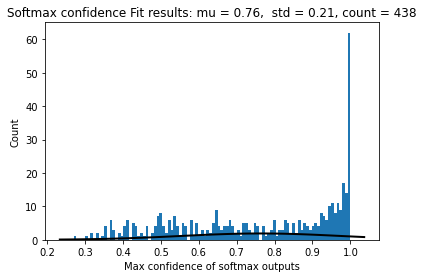

Tiny images plot


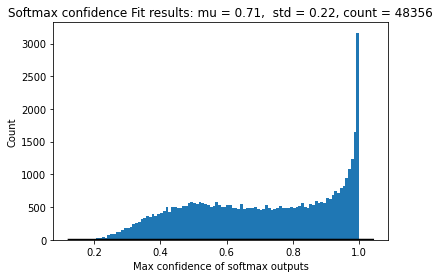

Cifat test plot


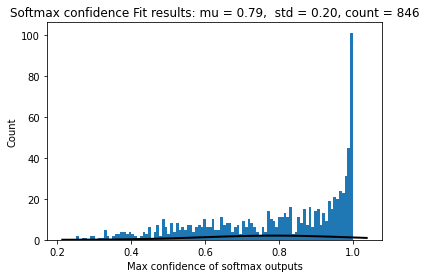

Cifar train plot


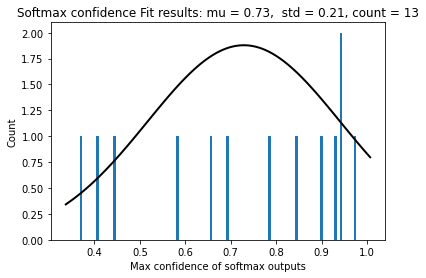

In [185]:
print("Ben recht plot")
plot_base_top_conf_on_hard_part_hist(br_base_scores, br_preds)
print("Tiny images plot")
plot_base_top_conf_on_hard_part_hist(ti_base_scores, ti_preds)
print("Cifat test plot")
plot_base_top_conf_on_hard_part_hist(cifar_base_scores, cifar_preds)
print("Cifar train plot")
plot_base_top_conf_on_hard_part_hist(cifar_train_base_scores, cifar_train_preds)

Ben recht plot


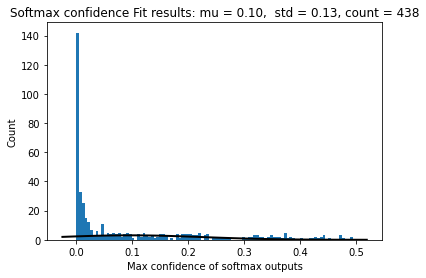

Tiny images plot


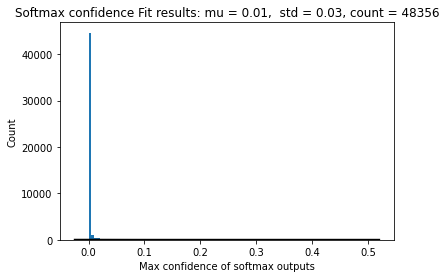

Cifat test plot


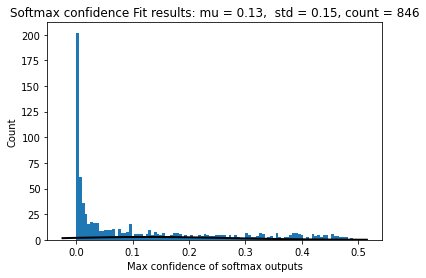

Cifar train plot


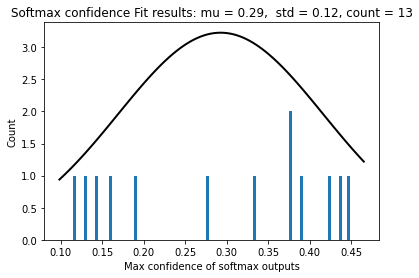

In [187]:
print("Ben recht plot")
plot_det_top_conf_on_hard_part_hist(br_det_scores, br_preds)
print("Tiny images plot")
plot_det_top_conf_on_hard_part_hist(ti_det_scores, ti_preds)
print("Cifat test plot")
plot_det_top_conf_on_hard_part_hist(cifar_det_scores, cifar_preds)
print("Cifar train plot")
plot_det_top_conf_on_hard_part_hist(cifar_train_det_scores, cifar_train_preds)

In [11]:
print("Percy detector cifar plot")
plot_df_hist(percy_cifar_scores)

Percy detector cifar plot


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7efbfcdb99d8> (for post_execute):


KeyboardInterrupt: 

In [22]:
p_d1_cifar = (percy_cifar_preds == det1_cifar_preds)
p_d2_cifar = (percy_cifar_preds == det2_cifar_preds)
d1_d2_cifar = (det1_cifar_preds == det2_cifar_preds)
all_cifar = ((det1_cifar_preds == det2_cifar_preds) & (det1_cifar_preds == percy_cifar_preds))

p_d1_unlab = (percy_unlab_preds == det1_unlab_preds)
p_d2_unlab = (percy_unlab_preds == det2_unlab_preds)
d1_d2_unlab = (det1_unlab_preds == det2_unlab_preds)
all_unlab = ((det1_unlab_preds == det2_unlab_preds) & (det1_unlab_preds == percy_unlab_preds))


print(p_d1_cifar.sum())
print(p_d2_cifar.sum())
print(d1_d2_cifar.sum())
print(all_cifar.sum())

print()

print(p_d1_unlab.sum())
print(p_d2_unlab.sum())
print(d1_d2_unlab.sum())
print(all_unlab.sum())

7629
7673
7796
6916

407123
409549
392060
364574


In [23]:
df = det1_cifar_preds[0:100]
df

0
0.0      3.0
1.0      8.0
2.0      8.0
3.0      0.0
4.0      6.0
        ... 
96.0     6.0
97.0     0.0
98.0     0.0
99.0     7.0
100.0    4.0
Name: 22, Length: 101, dtype: float64

det 1 for matching scores on cifar


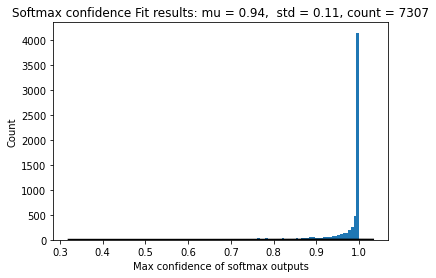

det 2 for matching scores on cifar


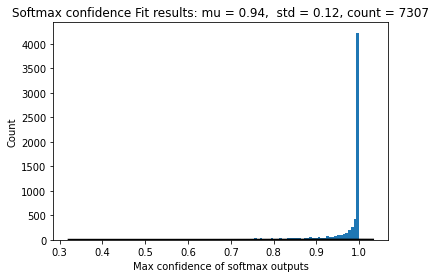

percy for matching scores on cifar


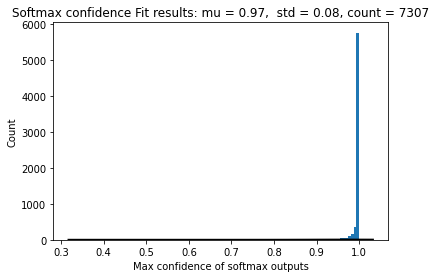

det 1 for non matching scores on cifar


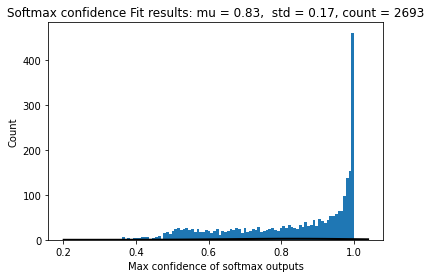

det 2 for non matching scores on cifar


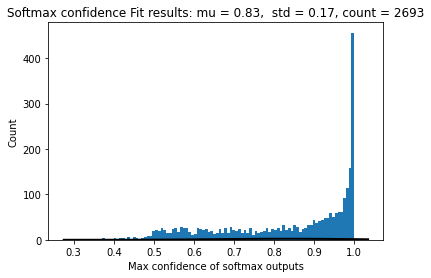

percy for non matching scores on cifar


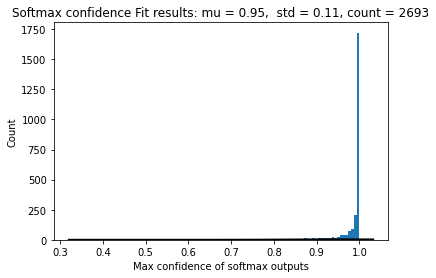

In [96]:
print('det 1 for matching scores on cifar')
plot_det_top_conf_hist(det1_cifar_scores[d1_d2_cifar])
print('det 2 for matching scores on cifar')
plot_det_top_conf_hist(det2_cifar_scores[d1_d2_cifar])
print('percy for matching scores on cifar')
plot_det_top_conf_hist(percy_cifar_scores[d1_d2_cifar])

print('det 1 for non matching scores on cifar')
plot_det_top_conf_hist(det1_cifar_scores[~d1_d2_cifar])
print('det 2 for non matching scores on cifar')
plot_det_top_conf_hist(det2_cifar_scores[~d1_d2_cifar])
print('percy for non matching scores on cifar')
plot_det_top_conf_hist(percy_cifar_scores[~d1_d2_cifar])


det 1 for matching scores on unlab


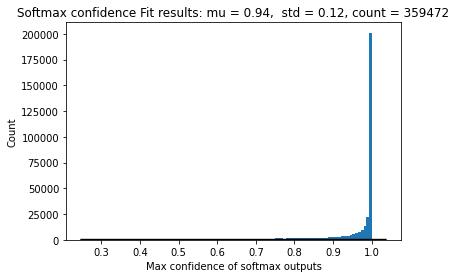

det 2 for matching scores on unlab


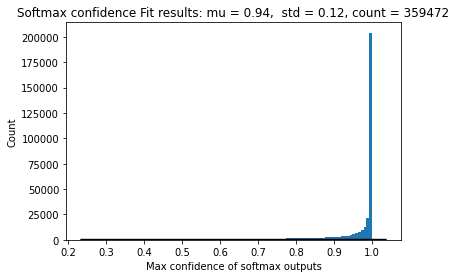

percy for matching scores on unlab


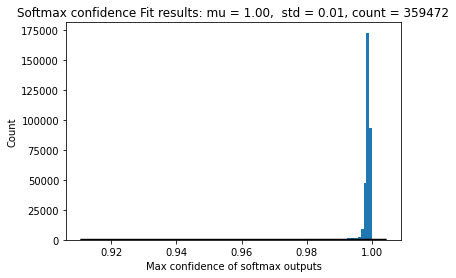

det 1 for non matching scores on unlab


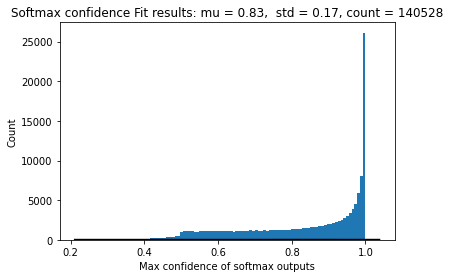

det 2 for non matching scores on unlab


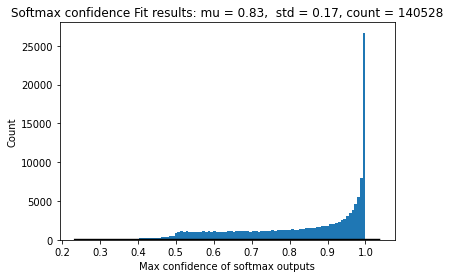

percy for non matching scores on unlab


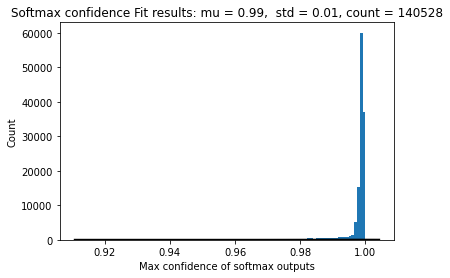

In [95]:
print('det 1 for matching scores on unlab')
plot_det_top_conf_hist(det1_unlab_scores[d1_d2_unlab])
print('det 2 for matching scores on unlab')
plot_det_top_conf_hist(det2_unlab_scores[d1_d2_unlab])
print('percy for matching scores on unlab')
plot_det_top_conf_hist(percy_unlab_scores[d1_d2_unlab])

print('det 1 for non matching scores on unlab')
plot_det_top_conf_hist(det1_unlab_scores[~d1_d2_unlab])
print('det 2 for non matching scores on unlab')
plot_det_top_conf_hist(det2_unlab_scores[~d1_d2_unlab])
print('percy for non matching scores on unlab')
plot_det_top_conf_hist(percy_unlab_scores[~d1_d2_unlab])


In [24]:
def get_combination_accs(model_preds, model_targets, p_d1, p_d2, d1_d2, all_df, filter = pd.Series()):
    if filter.any():
        model_preds = model_preds[filter]
        model_targets = model_targets[filter]
        p_d1 = p_d1[filter]
        p_d2 = p_d2[filter]
        d1_d2 = d1_d2[filter]
        all_df = all_df[filter]
    acc0 = ((model_preds==model_targets).sum()) / model_targets.count() * 100
    acc1 = ((model_preds[p_d1]==model_targets[p_d1]).sum()) / model_targets[p_d1].count() * 100
    acc2 = ((model_preds[p_d2]==model_targets[p_d2]).sum()) / model_targets[p_d2].count() * 100
    acc3 = ((model_preds[d1_d2]==model_targets[d1_d2]).sum()) / model_targets[d1_d2].count() * 100
    acc4 = ((model_preds[all_df]==model_targets[all_df]).sum()) / model_targets[all_df].count() * 100
    acc5 = ((model_preds[~d1_d2]==model_targets[~d1_d2]).sum()) / model_targets[~d1_d2].count() * 100
    acc6 = ((model_preds[~p_d1]==model_targets[~p_d1]).sum()) / model_targets[~p_d1].count() * 100
    acc7 = ((model_preds[~p_d2]==model_targets[~p_d2]).sum()) / model_targets[~p_d2].count() * 100
#     print("%0.2f %0.2f %0.2f %0.2f %0.2f %0.2f %0.2f %0.2f %d" %(acc0, acc1, acc2, acc3, acc4, acc5, acc6, 
#                                                                  acc7, len(model_preds)))
    print("%0.2f %0.2f %0.2f %0.2f %0.2f %0.2f %0.2f %0.2f \t %d %d %d %d %d %d %d %d" 
                  %(acc0, acc1, acc2, acc3, acc4, acc5, acc6, acc7, 
                    len(model_preds), len(model_preds[p_d1]), len(model_preds[p_d2]), len(model_preds[d1_d2]), 
                    len(model_preds[all_df]), len(model_preds[~d1_d2]), len(~p_d1), len(~p_d2) 
                   ))
    

/afs/cs.wisc.edu/u/v/g/vgoelsj/pythonprojects/sec_proj/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [27]:
get_combination_accs(det1_cifar_preds, det1_cifar_targets, p_d1_cifar, p_d2_cifar, d1_d2_cifar, all_cifar)
get_combination_accs(det2_cifar_preds, det1_cifar_targets, p_d2_cifar, p_d1_cifar, d1_d2_cifar, all_cifar)
get_combination_accs(percy_cifar_preds, det1_cifar_targets, p_d2_cifar, p_d1_cifar, d1_d2_cifar, all_cifar)
get_combination_accs(det_comb_cifar_preds, det_comb_cifar_targets, p_d1_cifar, p_d2_cifar, d1_d2_cifar, all_cifar)
print()
get_combination_accs(det1_unlab_preds, det1_unlab_targets, p_d1_unlab, p_d2_unlab, d1_d2_unlab, all_unlab)
get_combination_accs(det2_unlab_preds, det1_unlab_targets, p_d2_unlab, p_d1_unlab, d1_d2_unlab, all_unlab)
get_combination_accs(percy_unlab_preds, det1_unlab_targets, p_d2_unlab, p_d1_unlab, d1_d2_unlab, all_unlab)
get_combination_accs(det_comb_unlab_preds, det_comb_unlab_targets, p_d1_unlab, p_d2_unlab, d1_d2_unlab, all_unlab)

79.83 99.03 89.63 91.57 99.22 38.29 18.05 47.53 	 10000 7629 7673 7796 6916 2204 10000 10000
80.23 99.01 90.09 91.57 99.22 40.11 18.31 48.50 	 10000 7673 7629 7796 6916 2204 10000 10000
89.98 99.01 99.03 93.32 99.22 78.18 60.21 60.86 	 10000 7673 7629 7796 6916 2204 10000 10000
82.90 96.32 96.16 91.57 99.22 52.22 39.73 39.19 	 10000 7629 7673 7796 6916 2204 10000 10000

81.40 99.11 88.70 92.97 99.46 39.37 3.75 48.32 	 500000 407123 409549 392060 364574 107940 500000 500000
81.93 99.15 89.26 92.97 99.46 41.83 3.94 49.79 	 500000 409549 407123 392060 364574 107940 500000 500000
97.79 99.15 99.11 98.69 99.46 94.53 91.61 91.99 	 500000 409549 407123 392060 364574 107940 500000 500000
85.10 96.15 96.14 92.97 99.46 56.51 36.68 35.11 	 500000 407123 409549 392060 364574 107940 500000 500000


In [26]:
det_comb_cifar_scores = pd.concat([det1_cifar_scores, det2_cifar_scores]).max(level=0)
det_comb_unlab_scores = pd.concat([det1_unlab_scores, det2_unlab_scores]).max(level=0)
det_comb_cifar_preds = det_comb_cifar_scores.idxmax(axis="columns").astype('int32') - 2
det_comb_unlab_preds = det_comb_unlab_scores.idxmax(axis="columns").astype('int32') - 2
det_comb_cifar_targets = det1_cifar_targets
det_comb_unlab_targets = det1_unlab_targets

In [16]:
det_comb_cifar_scores[:10]

,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,
0.0,1.114967e-07,7.231210e-08,1.769402e-06,9.972722e-01,6.014103e-09,1.807250e-03,7.503075e-05,1.043904e-08,3.714101e-07,7.064649e-10,0.236590
1.0,9.912562e-08,3.506131e-01,1.657847e-09,1.806827e-08,6.633868e-11,1.147521e-09,4.250730e-08,1.953150e-09,9.944443e-01,1.068926e-04,0.092611
2.0,6.152704e-03,1.736382e-02,6.205933e-06,1.987934e-08,2.334277e-08,8.166378e-08,2.071535e-06,2.395991e-07,9.746328e-01,3.859372e-03,0.863526
3.0,4.536644e-01,1.319470e-03,3.893565e-05,1.604110e-04,2.400716e-06,3.563522e-07,2.924120e-06,5.919347e-06,3.866347e-02,3.663035e-03,0.843545
4.0,1.849568e-09,2.995664e-06,6.979852e-07,6.145781e-05,6.242067e-07,7.540692e-08,9.987209e-01,1.947065e-09,2.631841e-08,3.189547e-07,0.023902
5.0,9.152903e-07,1.128893e-04,1.726705e-06,7.720503e-01,4.369373e-03,1.096481e-03,7.508857e-01,2.117330e-05,2.142391e-05,4.474687e-06,0.244610
6.0,4.734896e-07,4.887151e-02,8.998373e-07,5.976002e-04,2.743588e-08,3.617816e-04,5.075373e-06,4.885007e-05,3.918597e-05,7.400432e-01,0.995502
7.0,9.755156e-06,2.313904e-06,2.618811e-04,1.160031e-03,6.723423e-02,5.356698e-04,3.502481e-03,3.035545e-06,4.383707e-05,3.376065e-05,0.996103
8.0,2.178344e-08,3.076158e-07,4.698261e-08,9.999131e-01,8.719306e-03,1.004995e-03,1.077493e-04,5.526317e-07,1.525598e-07,4.080892e-08,0.989883


In [28]:
(percy_cifar_preds == 10).sum()
det1_hard_cifar_preds = det1_cifar_preds[percy_cifar_preds == 10]
det2_hard_cifar_preds = det2_cifar_preds[percy_cifar_preds == 10]
det1_easy_cifar_preds = det1_cifar_preds[percy_cifar_preds != 10]
det2_easy_cifar_preds = det2_cifar_preds[percy_cifar_preds != 10]

In [29]:
easy_filter = percy_cifar_preds != 10
hard_filter = percy_cifar_preds == 10
get_combination_accs(det1_cifar_preds, det1_cifar_targets, p_d1_cifar, p_d2_cifar, d1_d2_cifar, all_cifar, easy_filter)
get_combination_accs(det2_cifar_preds, det1_cifar_targets, p_d2_cifar, p_d1_cifar, d1_d2_cifar, all_cifar, easy_filter)
get_combination_accs(det1_cifar_preds, det1_cifar_targets, p_d1_cifar, p_d2_cifar, d1_d2_cifar, all_cifar, hard_filter)
get_combination_accs(det2_cifar_preds, det1_cifar_targets, p_d2_cifar, p_d1_cifar, d1_d2_cifar, all_cifar, hard_filter)

82.98 99.03 89.63 93.46 99.22 39.82 2.69 48.55 	 9154 7629 7673 7366 6916 1788 9154 9154
83.45 99.01 90.09 93.46 99.22 42.23 2.84 50.23 	 9154 7673 7629 7366 6916 1788 9154 9154
45.74 nan nan 59.30 nan 31.73 45.74 45.74 	 846 0 0 430 0 416 846 846
45.39 nan nan 59.30 nan 31.01 45.39 45.39 	 846 0 0 430 0 416 846 846


/afs/cs.wisc.edu/u/v/g/vgoelsj/pythonprojects/sec_proj/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/afs/cs.wisc.edu/u/v/g/vgoelsj/pythonprojects/sec_proj/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
/afs/cs.wisc.edu/u/v/g/vgoelsj/pythonprojects/sec_proj/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


In [36]:
(det1_cifar_targets == 10).sum()

0

In [30]:
x2 = (det1_cifar_preds == 10)
x1 = (det1_cifar_preds != 10)

y2 = (det2_cifar_preds == 10)
y1 = (det2_cifar_preds != 10)

print((x1&y1).sum())
print((x1&y2).sum())
print((x2&y1).sum())
print((x2&y2).sum())

10000
0
0
0


In [31]:
(x1&y1).sum()

10000

In [32]:
(det1_cifar_preds == det2_cifar_preds).sum()

7796

In [31]:
print((x1&y1).sum())

0
0.0       False
1.0       False
2.0       False
3.0        True
4.0       False
          ...  
9995.0     True
9996.0    False
9997.0    False
9998.0    False
9999.0    False
Name: 23, Length: 10000, dtype: bool

In [26]:
(det1_cifar_preds[x1&y1] == det1_cifar_targets[x1&y1]).sum()

5741

In [33]:
get_combination_accs(det1_cifar_preds, det1_cifar_targets, p_d1_cifar, p_d2_cifar, d1_d2_cifar, all_cifar, x1&y1)
get_combination_accs(det2_cifar_preds, det2_cifar_targets, p_d1_cifar, p_d2_cifar, d1_d2_cifar, all_cifar, x1&y1)

79.83 99.03 89.63 91.57 99.22 38.29 18.05 47.53 	 10000 7629 7673 7796 6916 2204 10000 10000
80.23 90.09 99.01 91.57 99.22 40.11 48.50 18.31 	 10000 7629 7673 7796 6916 2204 10000 10000


In [34]:
get_combination_accs(det1_cifar_preds, det1_cifar_targets, p_d1_cifar, p_d2_cifar, d1_d2_cifar, all_cifar, x1&y2)
get_combination_accs(det2_cifar_preds, det2_cifar_targets, p_d1_cifar, p_d2_cifar, d1_d2_cifar, all_cifar, x2&y1)

79.83 99.03 89.63 91.57 99.22 38.29 18.05 47.53 	 10000 7629 7673 7796 6916 2204 10000 10000
80.23 90.09 99.01 91.57 99.22 40.11 48.50 18.31 	 10000 7629 7673 7796 6916 2204 10000 10000


In [30]:
(det1_cifar_preds == det1_cifar_targets).sum()

6586

In [35]:
print((det1_cifar_preds[x1&y1] == det1_cifar_targets[x1&y1]).sum())
print((det1_cifar_preds[x1&y2] == det1_cifar_targets[x1&y2]).sum())

print((det2_cifar_preds[x1&y1] == det2_cifar_targets[x1&y1]).sum())
print((det2_cifar_preds[x2&y1] == det1_cifar_targets[x2&y1]).sum())

7983
0
8023
0


In [39]:
det1_cifar_scores.iloc[0:10,0:10]

,2,3,4,5,6,7,8,9,10,11
0,,,,,,,,,,
0.0,1.114967e-07,3.741487e-08,1.769402e-06,7.632937e-01,6.014103e-09,3.963859e-05,7.503075e-05,1.043904e-08,4.171540e-09,5.555008e-10
1.0,1.381484e-08,3.453615e-07,1.267876e-11,2.826447e-12,3.187142e-11,1.602296e-11,5.937298e-11,5.998909e-13,9.944443e-01,6.149069e-09
2.0,6.152704e-03,1.736382e-02,6.205933e-06,1.987934e-08,2.334277e-08,8.166378e-08,2.071535e-06,1.805508e-07,1.090900e-01,3.859372e-03
3.0,4.536644e-01,7.091383e-05,3.893565e-05,5.103375e-06,2.400716e-06,2.844765e-07,2.924120e-06,5.919347e-06,7.243146e-03,3.663035e-03
4.0,1.270920e-13,3.334088e-07,2.994500e-07,3.889021e-07,4.112803e-07,6.068177e-12,9.987209e-01,2.130399e-12,2.631841e-08,2.665687e-10
5.0,9.152903e-07,1.128893e-04,1.819191e-08,7.720503e-01,1.574781e-06,1.096481e-03,6.879067e-02,1.311090e-06,8.114349e-06,4.474687e-06
6.0,4.734896e-07,3.587689e-03,8.998373e-07,1.576996e-04,2.743588e-08,3.617816e-04,5.075373e-06,4.885007e-05,3.918597e-05,2.960510e-04
7.0,9.755156e-06,2.313904e-06,2.618811e-04,3.036315e-06,1.205659e-06,3.596666e-05,3.502481e-03,3.035545e-06,4.383707e-05,3.376065e-05
8.0,2.178344e-08,3.076158e-07,4.698261e-08,2.843358e-04,8.719306e-03,1.004995e-03,1.077493e-04,5.526317e-07,1.525598e-07,4.080892e-08


In [37]:
# det1_cifar_scores.iloc[2:12][0:10]
det1_cifar_pseudo_preds = det1_cifar_scores.iloc[:,0:10].idxmax(axis="columns").astype('int32') - 2
det2_cifar_pseudo_preds = det2_cifar_scores.iloc[:,0:10].idxmax(axis="columns").astype('int32') - 2

det1_unlab_pseudo_preds = det1_unlab_scores.iloc[:,0:10].idxmax(axis="columns").astype('int32') - 2
det2_unlab_pseudo_preds = det2_unlab_scores.iloc[:,0:10].idxmax(axis="columns").astype('int32') - 2
d1_d2_pseudo_cifar = (det1_cifar_pseudo_preds == det2_cifar_pseudo_preds)

In [38]:
get_combination_accs(det1_cifar_pseudo_preds, det1_cifar_targets, p_d1_cifar, p_d2_cifar, d1_d2_pseudo_cifar, all_cifar, easy_filter)
get_combination_accs(det2_cifar_pseudo_preds, det1_cifar_targets, p_d2_cifar, p_d1_cifar, d1_d2_pseudo_cifar, all_cifar, easy_filter)
get_combination_accs(det1_cifar_pseudo_preds, det1_cifar_targets, p_d1_cifar, p_d2_cifar, d1_d2_pseudo_cifar, all_cifar, hard_filter)
get_combination_accs(det2_cifar_pseudo_preds, det1_cifar_targets, p_d2_cifar, p_d1_cifar, d1_d2_pseudo_cifar, all_cifar, hard_filter)

82.98 99.03 89.63 93.46 99.22 39.82 2.69 48.55 	 9154 7629 7673 7366 6916 1788 9154 9154
83.45 99.01 90.09 93.46 99.22 42.23 2.84 50.23 	 9154 7673 7629 7366 6916 1788 9154 9154
45.74 nan nan 59.30 nan 31.73 45.74 45.74 	 846 0 0 430 0 416 846 846
45.39 nan nan 59.30 nan 31.01 45.39 45.39 	 846 0 0 430 0 416 846 846


/afs/cs.wisc.edu/u/v/g/vgoelsj/pythonprojects/sec_proj/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/afs/cs.wisc.edu/u/v/g/vgoelsj/pythonprojects/sec_proj/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
/afs/cs.wisc.edu/u/v/g/vgoelsj/pythonprojects/sec_proj/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


In [36]:
get_combination_accs(det1_cifar_preds, det1_cifar_targets, p_d1_cifar, p_d2_cifar, d1_d2_cifar, all_cifar, easy_filter)
get_combination_accs(det2_cifar_preds, det1_cifar_targets, p_d2_cifar, p_d1_cifar, d1_d2_cifar, all_cifar, easy_filter)
get_combination_accs(det1_cifar_preds, det1_cifar_targets, p_d1_cifar, p_d2_cifar, d1_d2_cifar, all_cifar, hard_filter)
get_combination_accs(det2_cifar_preds, det1_cifar_targets, p_d2_cifar, p_d1_cifar, d1_d2_cifar, all_cifar, hard_filter)

82.98 99.03 89.63 93.46 99.22 39.82 2.69 48.55 	 9154 7629 7673 7366 6916 1788 9154 9154
83.45 99.01 90.09 93.46 99.22 42.23 2.84 50.23 	 9154 7673 7629 7366 6916 1788 9154 9154
45.74 nan nan 59.30 nan 31.73 45.74 45.74 	 846 0 0 430 0 416 846 846
45.39 nan nan 59.30 nan 31.01 45.39 45.39 	 846 0 0 430 0 416 846 846


/afs/cs.wisc.edu/u/v/g/vgoelsj/pythonprojects/sec_proj/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/afs/cs.wisc.edu/u/v/g/vgoelsj/pythonprojects/sec_proj/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
/afs/cs.wisc.edu/u/v/g/vgoelsj/pythonprojects/sec_proj/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
